# Youtube URL Linked to News

In [2]:
import psycopg2
import pandas as pd
import config
from matplotlib import pylab as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
import re
from urllib.parse import parse_qs,urlparse


color_palette = sns.color_palette(palette='muted', n_colors=None, desat=.75)
sns.set(context='notebook', palette=color_palette, style='whitegrid', font='sans-serif', font_scale=1.5, color_codes=False, rc=None)
pd.set_option('display.max_colwidth', -1)
table_styles = [{'selector': 'td',
                 'props': [('min-width', '100px'), ('text-align', 'center')]},
                {'selector': 'tr',
                 'props': [('border-bottom', '1px dotted black')]},
                {'selector': 'th',
                 'props': [('text-align', 'center')]}
               ]

%matplotlib inline

directory = "url_top_lists/"
stream = "comparison"

/media/raid/home/pflugmacher/virtualenv/twitterenvold/lib/python3.4/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/media/raid/home/pflugmacher/virtualenv/twitterenvold/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
conn = None
try:
    # read connection parameters
    paramsS17 = config.cfgAzureS17()
    paramsS03 = config.cfgAzureS03()

    paramsF17 = config.cfgAzureF17()
    paramsF03 = config.cfgAzureF03()
    
    # connect to the PostgreSQL server
    print('Connecting to the PostgreSQL database...')
    connS17 = psycopg2.connect(**paramsS17)
    connS03 = psycopg2.connect(**paramsS03)
    
    connF17 = psycopg2.connect(**paramsF17)
    connF03 = psycopg2.connect(**paramsF03)

    # create a cursor
    curS17 = connS17.cursor()
    curS03 = connS03.cursor()
    
    curF17 = connF17.cursor()
    curF03 = connF03.cursor()

    # execute a statement
    print('PostgreSQL database version:')
    
    curS17.execute('SELECT version()')
    curS03.execute('SELECT version()')
    curF17.execute('SELECT version()')
    curF03.execute('SELECT version()')
    
    # display the PostgreSQL database server version
    db_version_curS17 = curS17.fetchone()
    db_version_curS03 = curS03.fetchone()
    db_version_curF17 = curF17.fetchone()
    db_version_curF03 = curF03.fetchone()
    
    print(db_version_curS17)
    print(db_version_curS03)
    print(db_version_curF17)
    print(db_version_curF03)

    # close the communication with the PostgreSQL
    curS17.close()
    curS03.close()
    curF17.close()
    curF03.close()

except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)


## Util Methods

In [4]:
def compareRows(row, df_to_compare, column_name):
    comparison_row = df_to_compare.loc[df_to_compare[column_name] == row[column_name]]
    if comparison_row.empty:
        comparison = " - "
    else:
        percentage_dif = row['percentage'] - comparison_row['percentage'].values[0]
        difference = "(%s. / %.3f%% / %.3f%%)" % (comparison_row['rank'].values[0], comparison_row['percentage'].values[0], percentage_dif)
        if comparison_row['rank'].values[0] == row['rank']:
            comparison = " = <br>" + difference
        else:
            if comparison_row['rank'].values[0] > row['rank']:
                comparison = " v <br>" + difference
            else:
                comparison = " ^ <br>" + difference
    return comparison

def getOpacity(val):
    value = abs(float(re.findall(r"[-+]?\d*\.\d+|\d+", val.split("/")[2])[0]))
    if value < 0.005:
        return 1
    if value < 0.01:
        return 0.95
    if value < 0.05:
        return 0.8
    if value < 0.1:
        return 0.7
    if value < 0.5:
        return 0.6
    if value < 1:
        return 0.5
    if value < 10:
        return 0.3
    if value < 40:
        return 0.2
    if value < 80:
        return 0.1
    if value < 100:
        return 0.05

def colorComparisonField(val):
    
    if isinstance(val, str):
        if ' ^ ' in val or ' v ' in val:
            return 'background-color: rgba(246, 185, 59, %s)' %getOpacity(val)
        if ' = ' in val:
            return 'background-color: rgba(184, 233, 148, %s)' %getOpacity(val)
        if ' - ' in val and len(val) == 3:
            return 'background-color: #e55039' 
    return ''

def generateRankingDataframe(series, attribute_name):
    size = series.sum()
    rank = []
    parameter = []
    count = []
    percentage = []

    i = 1
    for index, value in series.iteritems():
        rank.append(i)
        parameter.append(index)
        count.append(value)
        percentage.append((value/size)*100)
        i += 1

    data = {'rank': rank, attribute_name: parameter, 'value': count, 'percentage': percentage}
    return pd.DataFrame(data=data)

def generateComparisonDataframes(df1, df2, column_name, size):
    compare_list = []
    for index, row in df1.iterrows():
        if row['rank'] <= size:
            compare_list.append(compareRows(row, df2, column_name))

    data = {'rank': df1['rank'][:size], column_name: df1[column_name][:size], 'value': df1['value'][:size], 'percentage': df1['percentage'][:size],
            'difference (rank / percentage / diff)': compare_list}
    
    df1_compared = pd.DataFrame(data=data)
    df1_compared.set_index(keys='rank', inplace=True)
    
    compare_list = []
    for index, row in df2.iterrows():
        if row['rank'] <= size:
            compare_list.append(compareRows(row, df1, column_name))

    data = {'rank': df2['rank'][:size], column_name: df2[column_name][:size], 'value': df2['value'][:size], 'percentage': df2['percentage'][:size],
            'difference (rank / percentage / diff)': compare_list}
    
    df2_compared = pd.DataFrame(data=data)
    df2_compared.set_index(keys='rank', inplace=True)
    
    return df1_compared, df2_compared

def getPrettyComparisonDataframe(df, title):
    s = df.style.applymap(colorComparisonField)
    s.set_caption(title)
    s.set_table_styles(table_styles)
    return s

## Query URLs - Sampled

In [5]:
urlsS03 = pd.read_sql_query("SELECT * FROM tweets_urls;", connS03 )
print("# of URLs sampled 03: %s" %len(urlsS03))

urlsS17 = pd.read_sql_query("SELECT * FROM tweets_urls;", connS17 )
print("# of URLs sampled 17: %s" %len(urlsS17))

urlsS = urlsS17.append(urlsS03)
print("# of URLs sampled: %s" %len(urlsS))

urlsS.head()

# of URLs sampled 03: 40339
# of URLs sampled 17: 35687
# of URLs sampled: 76026


,tweet_id,short_url,resolved_url,response_code,domain,top_level_domain,is_twitter_url,is_media,is_processed,failed
0,989097603664138240,http://arte.tv/abgedreht,https://www.arte.tv/de/videos/RC-014033/abgedreht/,200.0,https://www.arte.tv/,arte.tv,False,False,True,False
1,988175933659021318,https://twitter.com/piersmorgan/status/987388203593322496,https://twitter.com/piersmorgan/status/987388203593322496,200.0,https://twitter.com/,twitter.com,True,False,True,False
2,988176164358361088,https://www.journal.koeln/pol-ham-fahrradfahrer-verletzt-sich-bei-sturz/,https://www.journal.koeln/pol-ham-fahrradfahrer-verletzt-sich-bei-sturz/,200.0,https://www.journal.koeln/,journal.koeln,False,False,True,False
3,988176403412766720,http://www.radionomy.com/erika1,https://www.radionomy.com/en/radio/erika1,200.0,https://www.radionomy.com/,radionomy.com,False,False,True,False
4,988176415995592704,https://twitter.com/JanLatten/status/988161845205913600,https://twitter.com/JanLatten/status/988161845205913600,200.0,https://twitter.com/,twitter.com,True,False,True,False


## Query Hashtags - Sampled

In [6]:
hashtagsS03 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connS03 )
print("# of hashtags sampled 03: %s" %len(hashtagsS03))

hashtagsS17 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connS17 )
print("# of hashtags sampled 17: %s" %len(hashtagsS17))

hashtagsS = hashtagsS17.append(hashtagsS03)
print("# of URLs sampled: %s" %len(hashtagsS))

hashtagsS.head()

# of hashtags sampled 03: 84203
# of hashtags sampled 17: 73935
# of URLs sampled: 158138


,tweet_id,hashtag
0,988175614908788736,wetter
1,988176244029251584,MTVBRPETNUGGET
2,988176244029251584,MTVBRSHADETAYLORKATY
3,988176244029251584,PremiosMTVMiaw
4,988176244029251584,MTVLAINSTAGLCAMILAC


## Query URLs - Filtered

In [7]:
urlsF03 = pd.read_sql_query("SELECT * FROM tweets_urls;", connF03 )
print("# of URLs filtered 03: %s" %len(urlsF03))

urlsF17 = pd.read_sql_query("SELECT * FROM tweets_urls;", connF17 )
print("# of URLs filtered 17: %s" %len(urlsF17))

urlsF = urlsF17.append(urlsF03)
print("# of URLs filtered: %s" %len(urlsF))

urlsF.head()

# of URLs filtered 03: 2411523
# of URLs filtered 17: 2107279
# of URLs filtered: 4518802


,tweet_id,short_url,resolved_url,response_code,domain,top_level_domain,is_twitter_url,is_media,is_processed,failed
0,988437985363406853,https://www.facebook.com/nadjashah/posts/10215947002527277,https://www.facebook.com/nadjashah/posts/10215947002527277,200.0,https://www.facebook.com/,facebook.com,False,False,True,False
1,988437986797916160,https://www.facebook.com/StageSchoolHamburg/posts/1934173349947359,https://www.facebook.com/StageSchoolHamburg/posts/1934173349947359,200.0,https://www.facebook.com/,facebook.com,False,False,True,False
2,988437989712957440,http://www.faz.net/aktuell/rhein-main/frankfurt/frankfurter-gutleutviertel-landgericht-erlaubt-drohende-zwangsraeumung-15556433.html,http://www.faz.net/aktuell/rhein-main/frankfurt/frankfurter-gutleutviertel-landgericht-erlaubt-drohende-zwangsraeumung-15556433.html,200.0,http://www.faz.net/,faz.net,False,False,True,False
3,988437989704568832,http://vera-lengsfeld.de/2018/04/22/buergerprotest-ueberall-wie-lange-wird-das-noch-verschwiegen/,http://vera-lengsfeld.de/2018/04/22/buergerprotest-ueberall-wie-lange-wird-das-noch-verschwiegen/,200.0,http://vera-lengsfeld.de/,vera-lengsfeld.de,False,False,True,False
4,988437990732128256,https://ift.tt/2Jm4wnp,https://news.google.com/?sa=t&fd=R&ct2=de&usg=AFQjCNFSz3Yf_fDFIytLtnNe8JNGM2BPZg&clid=c3a7d30bb8a4878e06b80cf16b898331&ei=O_rdWqDIHNCT3QHCyJDQAg&url=https://www.waz.de/kultur/fuer-silke-j-raebiger-ist-es-das-letzte-frauen-filmfestival-id214100661.html&taa=1&hl=en-US&gl=US&ceid=US:en,200.0,https://news.google.com/,google.com,False,False,True,False


## Query Hashtags - Filtered

In [8]:
hashtagsF03 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connF03 )
print("# of hashtags filtered 03: %s" %len(hashtagsS03))

hashtagsF17 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connF17 )
print("# of hashtags filtered 17: %s" %len(hashtagsS17))

hashtagsF = hashtagsF17.append(hashtagsF03)
print("# of URLs filtered: %s" %len(hashtagsF))

hashtagsF.head()

# of hashtags filtered 03: 84203
# of hashtags filtered 17: 73935
# of URLs filtered: 8158028


,tweet_id,hashtag
0,988175612497063936,Mercedes
1,988175612497063936,Perkasie
2,988175612497063936,carsforsale
3,988175612945854465,reiseagentur
4,988175612945854465,cancelflights


## Query Hashtags by Tweets - Filtered 

In [15]:
hashtagsTF03 = pd.read_sql_query("SELECT id as tweet_id, hashtags FROM tweets_info;", connF03 )
print("# of hashtags filtered 03: %s" %len(hashtagsTF03))

hashtagsTF17 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connF17 )
print("# of hashtags filtered 17: %s" %len(hashtagsTF17))

hashtagsTF = hashtagsTF17.append(hashtagsTF03)
print("# of URLs filtered: %s" %len(hashtagsTF))

hashtagsTF.head()

# of hashtags filtered 03: 8010674
# of hashtags filtered 17: 3780197
# of URLs filtered: 11790871


,hashtag,hashtags,tweet_id
0,Mercedes,NaN,988175612497063936
1,Perkasie,NaN,988175612497063936
2,carsforsale,NaN,988175612497063936
3,reiseagentur,NaN,988175612945854465
4,cancelflights,NaN,988175612945854465


## Dataframes Used

In [21]:
_hashtags = hashtagsF
_hashtags_t = hashtagsTF
_urls = urlsF

In [20]:
def getURLsByHashtag(hashtag, hashtags, urls):
    return urls[urls['tweet_id'].isin(hashtags[hashtags['hashtag'] == hashtag]["tweet_id"])]

In [29]:
getURLsByHashtag("GameInsight", _hashtags, urlsF)['top_level_domain'].value_counts()

17bullets.com       12336
tinyurl.co          1798 
tinyurl.com         1706 
game-insight.com    42   
ebayjunkies.com     5    
dotomi.com          3    
gigam.es            2    
apple.com           1    
qksrv.net           1    
t.me                1    
Name: top_level_domain, dtype: int64

In [14]:
_hashtags['hashtag'].value_counts()[:50]

AfD                    77211
SPD                    69911
spdbpt18               53507
ibes                   49874
GroKo                  41034
Merkel                 38548
Friederike             38418
Berlin                 37907
IBES                   26345
Deutschland            24908
FCBRMA                 24660
CSU                    24044
GameInsight            23820
ParadiseIsland2        23710
NoGroKo                21730
CDU                    20778
miete                  19901
mietpreise             19876
jobs                   19023
Kreuz                  18599
iHeartAwards           18540
Amazon                 17889
Hamburg                17414
ReconquistaInternet    17127
Bundestag              16823
Antisemitismus         16349
Germany                16183
Afrin                  16125
Schulz                 16018
Trump                  15749
BTS                    15668
Bayern                 15636
Digitalisierung        14781
ranNFL                 14326
EU            

In [19]:
_hashtags_t['hashtags'].value_counts()[:50]

ibes                               41783
spdbpt18                           25325
Friederike                         20662
IBES                               20566
AfD                                15148
SPD                                12210
jobs                               12135
GroKo                              9696 
Maischberger                       7671 
Bachelor                           7625 
Cottbus                            7579 
ParadiseIsland2 GameInsight        6433 
GameInsight ParadiseIsland2        6391 
정국 BTS BestBoyBand iHeartAwards    5760 
NoGroKo                            5475 
Berlin                             5430 
Merkel                             5227 
NowPlaying                         4980 
147sf                              4247 
reichenhetze                       3982 
Tatort                             3902 
ranNFL                             3785 
Afrin                              3641 
Schulz                             3617 
NetzDG          

## Youtube Links with Hashtags

In [6]:
youtube_urls_s = urlsS[urlsS['top_level_domain'] == 'youtube.com']
print("# of URLs in Dataframe: %s" %len(youtube_urls_s))

youtube_value_dict_s = {}
for url, count in youtube_urls_s['resolved_url'].value_counts().iteritems():
    video_tweets_url = youtube_urls_s[youtube_urls_s['resolved_url'] == url]
    hashtags = hashtagsS[hashtagsS['tweet_id'].isin(video_tweets_url['tweet_id'])]

    hashtags_ranking = hashtags['hashtag'].value_counts()
    hashtag_with_values = {}
    for tag, value in hashtags_ranking.iteritems():
        hashtag_with_values[tag] = value
    
    youtube_value_dict_s[url] = hashtag_with_values


# of URLs in Dataframe: 6223


In [89]:
len(youtube_value_dict_s.keys())

5175

## Most Popular official news publishers

In [7]:
top_publisher = ['welt.de', 'spiegel.de', 'focus.de', 'bild.de', 'faz.net', 
                 'sueddeutsche.de', 'zeit.de', 'tagesschau.de', 'presseportal.de', 'tagesspiegel.de',
                 'heise.de', 'n-tv.de', 'epochtimes.de', 'handelsblatt.com', 'derstandard.at',
                 'philosophia-perennis.com', 'journalistenwatch.com', 'tichyseinblick.de', 'taz.de', 'rp-online.de']

## Most Shared Articles with Hashtags

In [8]:
urls_by_publisher_s = urlsS[urlsS['top_level_domain'].isin(top_publisher)]

In [9]:
article_x_yt_matches = {}

for url, count in urls_by_publisher_s['resolved_url'].value_counts().iteritems():
    article_tweets_url = urls_by_publisher_s[urls_by_publisher_s['resolved_url'] == url]
    hashtags = hashtagsS[hashtagsS['tweet_id'].isin(article_tweets_url['tweet_id'])]

    hashtags_ranking = hashtags['hashtag'].value_counts()
    
    matched_urls = []
    matched_values = []
    
    for yt_url, yt_tag_value_dict in youtube_value_dict_s.items():
        yt_url_rating = {}
        matches = 0

        for tag, value in hashtags_ranking.iteritems():
            if tag in yt_tag_value_dict:
                yt_tag_value = yt_tag_value_dict[tag]
                
                if value <= yt_tag_value:
                    matches += value
                else:
                    matches += yt_tag_value

        if matches > 0:
            matched_urls.append(yt_url)
            matched_values.append(matches)
        
    article_x_yt_matches[url] = pd.Series(data=matched_values, index=matched_urls)
            

In [108]:
hashtagsS[hashtagsS['tweet_id']
          .isin(urls_by_publisher_s[urls_by_publisher_s['resolved_url'] == 'http://www.spiegel.de/spiegel/unispiegel/fh-dortmund-bietet-neuen-studiengang-fluechtlingshilfe-an-a-1196053.html']['tweet_id']
               )
         ]

,tweet_id,hashtag
41215,989526998870568966,CDU
41216,989526998870568966,AfD
42260,989549664688107520,Abschiebungen
42261,989549664688107520,Asyl
42262,989549664688107520,Migranten
42263,989549664688107520,Fakefugees
42264,989549664688107520,Germoney
42265,989549664688107520,Merkel
42266,989549664688107520,Groko
42267,989549664688107520,AfD


In [104]:
youtube_value_dict_s['https://www.youtube.com/watch?v=JXZFCQXApEY']

{'AfD': 2,
 'AfDwirkt': 2,
 'Bundestag': 1,
 'Hampel': 1,
 'Landtag': 1,
 'Retweet': 1,
 'Syrien': 2,
 'Syrienreise': 2,
 'Wendezeit': 2}

## Articles x Videos by Hashtag co-occurences

In [10]:
def getHashtagsFromURL(url, urls, hashtags):
    return hashtags[ hashtags['tweet_id'].isin(urls[urls['resolved_url'] == url]['tweet_id'])]

In [151]:
", ".join(getHashtagsFromURL("https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html", urlsS, hashtagsS)['hashtag'].unique())

'FluechtlingsIndustrie, Sozialverbände, Altparteien, Staatsmedien, FakeNews, Welt, Inzucht, taz, AfD, Anfrage, Fakten, Doppelmoral'

In [11]:
rank=1
for publisher in top_publisher[:1]:
    all_urls_by_publisher = urlsS[urlsS['top_level_domain'] == publisher]
    
    articles_counted_s = all_urls_by_publisher['resolved_url'].value_counts()
    
    print("rank", "publisher", "# shares", "# unique", "% unique", sep="\t")
    
    print(rank, publisher,
          len(all_urls_by_publisher),
          len(articles_counted_s),
          "%.2f%%" %(len(articles_counted_s)/len(all_urls_by_publisher)*100), 
          
          sep='\t')
    rank+=1
    print("", "#", "%", "article", "hashtags", sep="\t")
    
    for article, count in articles_counted_s[:5].iteritems():
        print("",
              count, 
              "%.2f%%" %(count/sum(articles_counted_s)*100), 
              article,
              ", ".join(getHashtagsFromURL(article, urlsS, hashtagsS)['hashtag'].unique()),
              sep='\t')
        
        if article in article_x_yt_matches:
            article_x_yt_matches[article].sort(ascending=False)
            print("", "", "#", "Youtube URL", "Hashtags", sep="\t")
            for matched_yt_url, count in article_x_yt_matches[article][:5].iteritems():
                print("",
                      "",
                      count,
                      matched_yt_url,
                      ", ".join(getHashtagsFromURL(matched_yt_url, urlsS, hashtagsS)['hashtag'].unique()),
                      sep="\t")
        else:
            print("", "", "", "", "", sep="\t")

rank	publisher	# shares	# unique	% unique
1	welt.de	1222	739	60.47%
	#	%	article	hashtags
	12	0.98%	https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html	FluechtlingsIndustrie, Sozialverbände, Altparteien, Staatsmedien, FakeNews, Welt, Inzucht, taz, AfD, Anfrage, Fakten, Doppelmoral


AttributeError: 'Series' object has no attribute 'sort'

In [25]:
no_articles_with_yt_urls_list = []
no_articles_without_yt_urls_list = []
no_articles_list = []
publisher_list = []
percentage_articles_with_yt_links_list = []
mean_yt_links_per_article_list = []
top10_mean_yt_links_per_article_list = []

for publisher in top_publisher[:20]:
    all_urls_by_publisher = urlsS[urlsS['top_level_domain'] == publisher]
    
    articles_counted_s = all_urls_by_publisher['resolved_url'].value_counts()
    
    youtube_links_found = 0
    youtube_links_not_found = 0
    sum_yt_links_per_article = 0
    sum_top_yt_links_per_article = 0
    top_limit = 10
    
    for article, count in articles_counted_s.iteritems():
        
        sum_yt_links_per_article += len(article_x_yt_matches[article])
        
        if len(article_x_yt_matches[article]) == 0:
            youtube_links_not_found += 1
        else:
            youtube_links_found += 1
    
    for article, count in articles_counted_s[:top_limit].iteritems():
        
        sum_top_yt_links_per_article += len(article_x_yt_matches[article])
        
    
    article_links_sum = youtube_links_not_found + youtube_links_found
    mean_yt_links_per_article = sum_yt_links_per_article / article_links_sum 
    mean_top_yt_links_per_article = sum_top_yt_links_per_article / top_limit
    
    print(youtube_links_found, 
          youtube_links_not_found, 
          "%.2f" %(youtube_links_found/(article_links_sum) * 100),
          "%.2f" %(mean_yt_links_per_article),
          "%.2f" %(mean_top_yt_links_per_article),
         publisher)
    
    no_articles_with_yt_urls_list.append(youtube_links_found)
    no_articles_without_yt_urls_list.append(youtube_links_not_found)
    no_articles_list.append(article_links_sum)
    publisher_list.append(publisher)
    percentage_articles_with_yt_links_list.append(youtube_links_found/(article_links_sum) * 100)
    mean_yt_links_per_article_list.append(mean_yt_links_per_article)
    top10_mean_yt_links_per_article_list.append(mean_top_yt_links_per_article)
    
    
    if publisher == "philosophia-perennis.com":
        for article, count in articles_counted_s.iteritems():
            print(len(article_x_yt_matches[article]))
            print(article_x_yt_matches[article])
             
data = {'publisher': publisher_list, 
        '# articles': no_articles_list,
        '# articles with yt links': no_articles_with_yt_urls_list,
        '# articles without yt links': no_articles_without_yt_urls_list,
        '% articles with yt links': percentage_articles_with_yt_links_list,
        'mean yt links per article': mean_yt_links_per_article_list,
        'mean top 10 links per article': top10_mean_yt_links_per_article_list,
       }

article_x_yt_df = pd.DataFrame(data=data)

137 602 18.54 2.28 22.30 welt.de
77 485 13.70 1.52 20.30 spiegel.de
75 399 15.82 1.48 7.40 focus.de
69 299 18.75 1.95 19.90 bild.de
91 327 21.77 1.71 3.50 faz.net
44 271 13.97 1.21 9.20 sueddeutsche.de
79 284 21.76 1.62 4.80 zeit.de
74 155 32.31 2.66 10.00 tagesschau.de
42 321 11.57 0.69 1.00 presseportal.de
77 147 34.38 3.13 11.40 tagesspiegel.de
45 151 22.96 1.00 7.80 heise.de
29 164 15.03 2.30 7.00 n-tv.de
26 146 15.12 1.46 3.50 epochtimes.de
35 156 18.32 1.38 0.60 handelsblatt.com
9 145 5.84 0.19 0.00 derstandard.at
40 33 54.79 7.40 17.10 philosophia-perennis.com
0
Series([], dtype: float64)
53
https://www.youtube.com/watch?v=ON6lah4m2yE&t=4s                                               1
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be                                   3
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/                                      2
https://www.youtube.com/watch?v=5Jx_cxzW6ak                                                    1
https:

In [43]:
mean_top_normal = pd.concat([article_x_yt_df['mean top 10 links per article'], article_x_yt_df['mean yt links per article']])
publisher_temp = pd.concat([article_x_yt_df['publisher'], article_x_yt_df['publisher']])
type_data = (len(article_x_yt_df['mean top 10 links per article']) * ["top 10 articles"] +
             len(article_x_yt_df['mean yt links per article']) * ["all articles"])

compare_yt_article_df = pd.DataFrame({"publisher":publisher_temp,"value":mean_top_normal, "type":type_data})


In [44]:
compare_yt_article_df

,publisher,type,value
0,welt.de,top 10 articles,22.300000
1,spiegel.de,top 10 articles,20.300000
2,focus.de,top 10 articles,7.400000
3,bild.de,top 10 articles,19.900000
4,faz.net,top 10 articles,3.500000
5,sueddeutsche.de,top 10 articles,9.200000
6,zeit.de,top 10 articles,4.800000
7,tagesschau.de,top 10 articles,10.000000
8,presseportal.de,top 10 articles,1.000000
9,tagesspiegel.de,top 10 articles,11.400000


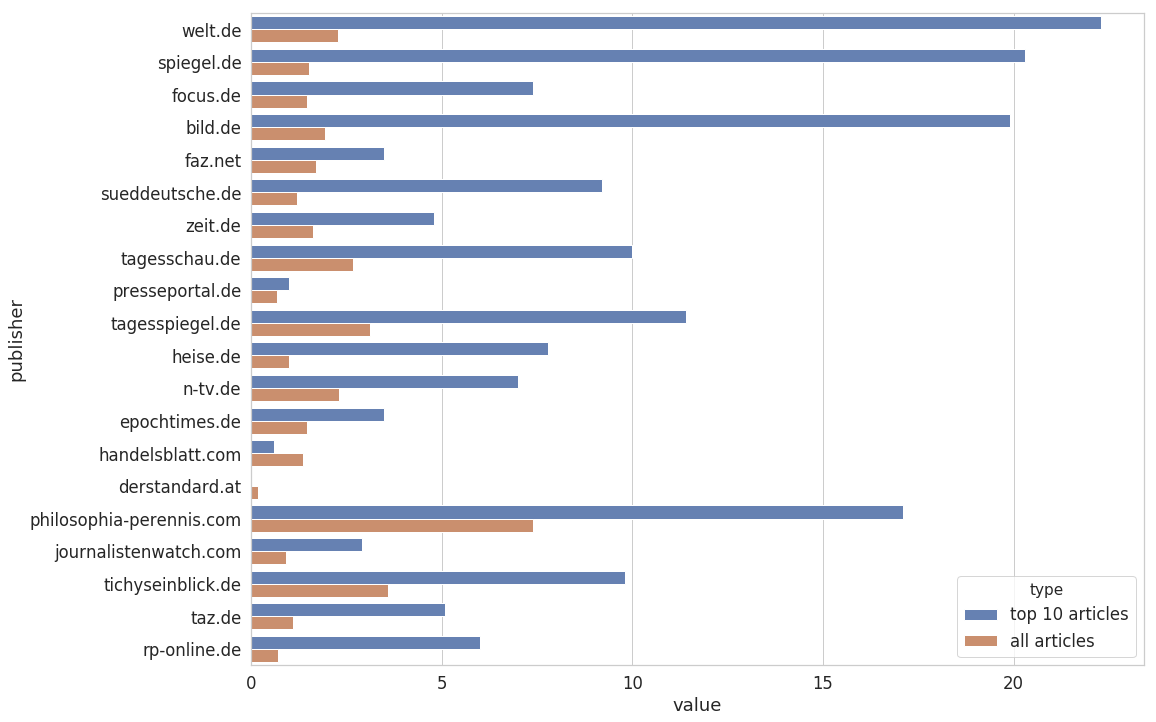

In [54]:
plt.figure(figsize=(16,12))

sns.barplot(y="publisher", x="value", hue="type",  data=compare_yt_article_df);

Text(0.5,0,'mean top 10 links per article')

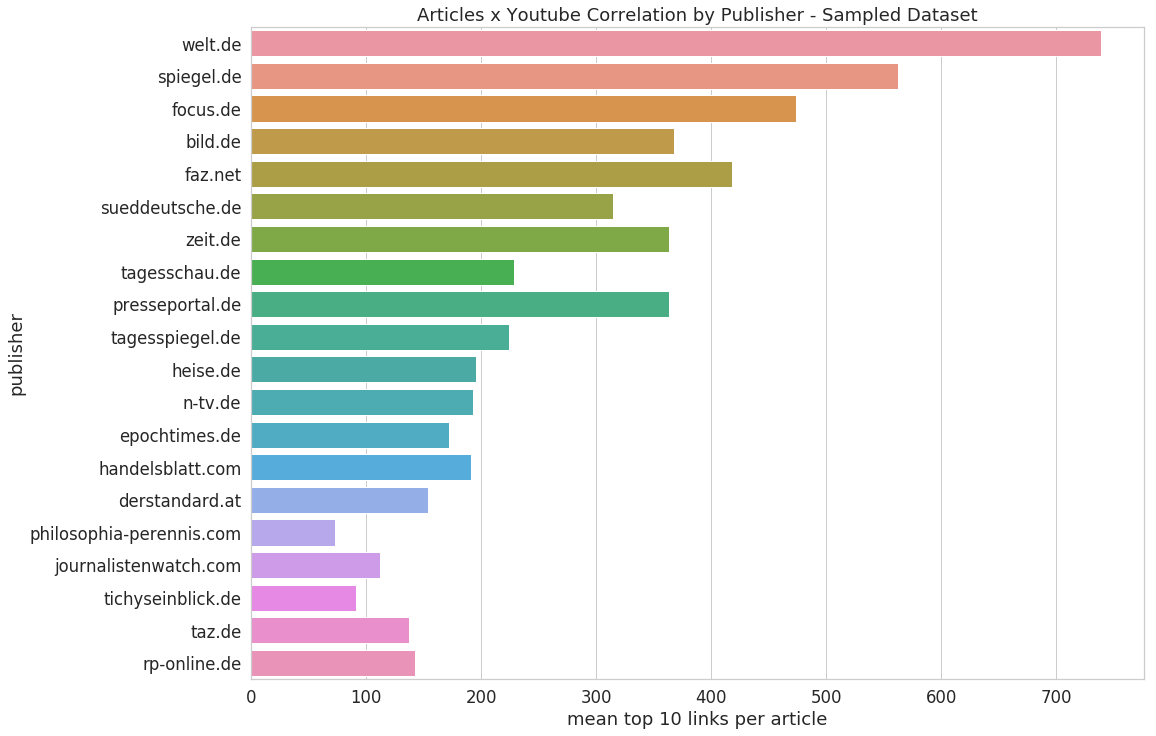

In [55]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['# articles'])
ax.set_title("Articles x Youtube Correlation by Publisher - Sampled Dataset")
ax.set_xlabel("mean top 10 links per article")

Text(0.5,0,'mean top 10 links per article')

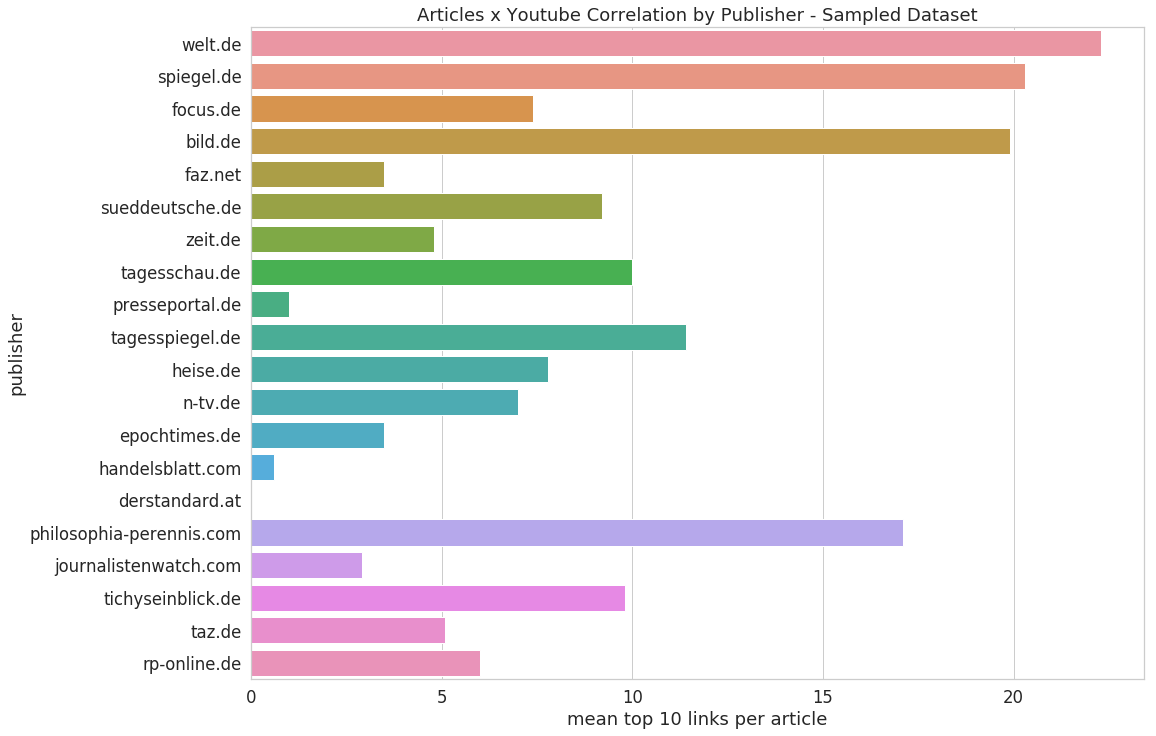

In [29]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['mean top 10 links per article'])
ax.set_title("Articles x Youtube Correlation by Publisher - Sampled Dataset")
ax.set_xlabel("mean top 10 links per article")

Text(0.5,0,'mean links per article')

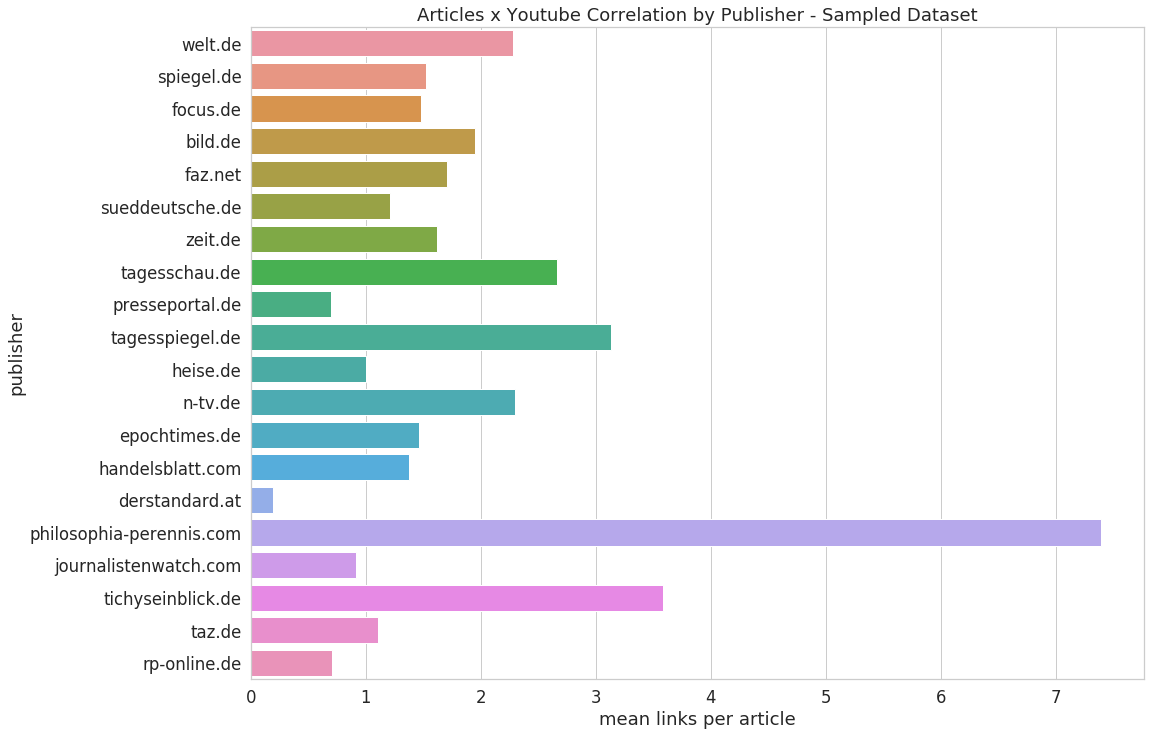

In [31]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['mean yt links per article'])
ax.set_title("Articles x Youtube Correlation by Publisher - Sampled Dataset")
ax.set_xlabel("mean links per article")

Text(0.5,0,'articles that can be assigned to youtube links by hashtags (mean) ')

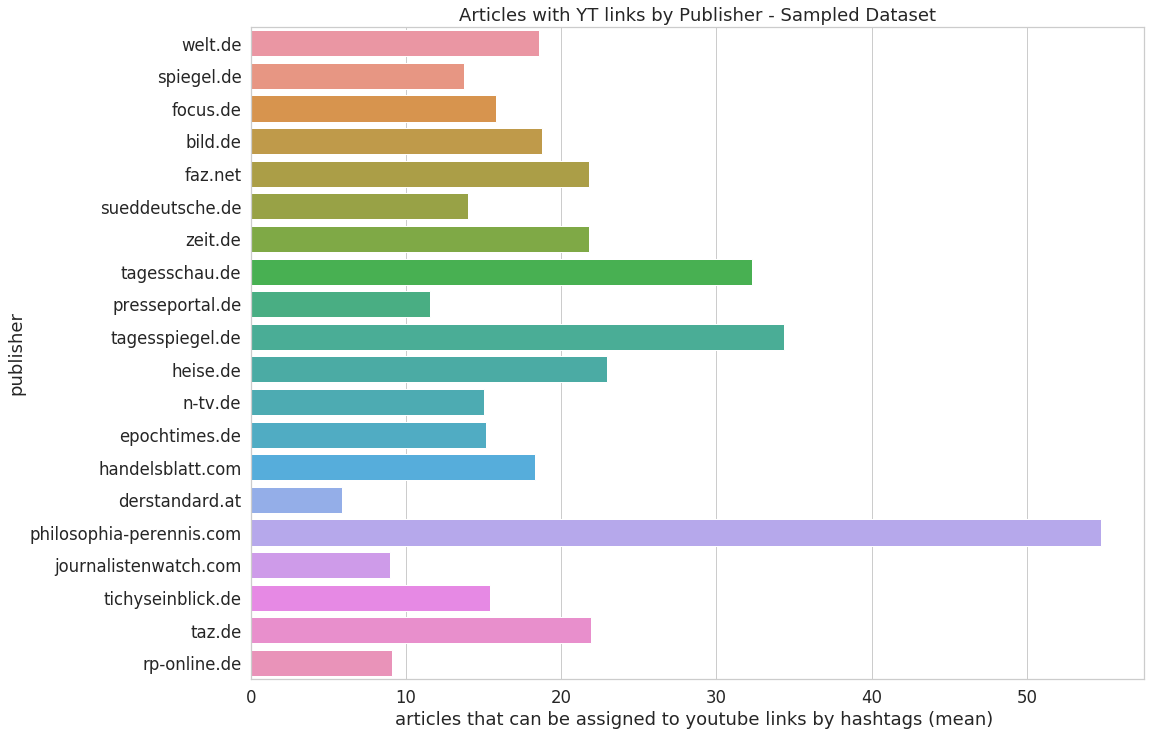

In [33]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['% articles with yt links'])
ax.set_title("Articles with YT links by Publisher - Sampled Dataset")
ax.set_xlabel("articles that can be assigned to youtube links by hashtags (mean) ")

## Youtube URLs with Articles by Hashtags

In [158]:
def compareHashtags(hashtags_a_dict, hashtags_b_dict):
    matches = 0
    for hashtag_a in hashtags_a_dict.keys():
        if hashtag_a in hashtags_b_dict:
            if hashtags_a_dict[hashtag_a] <= hashtags_b_dict[hashtag_a]:
                matches += hashtags_a_dict[hashtag_a]
            else:
                matches += hashtags_b_dict[hashtag_a]
    return matches
    if matches > 0:
        print(matches)
        print(hashtags_a_dict, hashtags_b_dict)

def common_member(a, b):
    
    a_set = set(a)
    b_set = set(b)
    #print(a_set, b_set)
    if (a_set & b_set):
        return True
    else:
        return False

In [66]:
urls_by_publisher = urlsS[urlsS['top_level_domain'].isin(top_publisher)]
print(len(urls_by_publisher))

8217


In [114]:
hashtags_by_article_url = {}
distinct_urls = urls_by_publisher['resolved_url'].unique()
print(len(distinct_urls))
for article in distinct_urls:
    hashtags = getHashtagsFromURL(article, urlsS, hashtagsS)
    
    if len(hashtags>0):
        hashtags_by_article_url[article] = hashtags['hashtag'].value_counts().to_dict()
    

5517


In [115]:
len(hashtags_by_article_url)

2190

In [142]:
len(distinct_urls)

5517

In [147]:
hashtags_by_article_url['http://www.spiegel.de/spiegel/print/index-2018-17.html']

{'AfD': 1, 'Bundestag': 1, 'Deutschland': 1, 'Hamburg': 1, 'Spiegel': 1}

In [ ]:
def getHashtagsFromURL(url, urls, hashtags):
    return hashtags[ hashtags['tweet_id'].isin(urls[urls['resolved_url'] == url]['tweet_id'])]

youtube_with_article_matches = {}

for yt_url, count in youtube_urls_s['resolved_url'].value_counts().iteritems():
    #print(yt_url, count)
    hashtags_yt_url = getHashtagsFromURL(yt_url, urlsS, hashtagsS)
    #print(hashtags_yt_url['hashtag'].value_counts())
    if len(hashtags_yt_url > 0):
        article_matched = []
        article_match_count = []
        for article_url in distinct_urls:
            
            #print(article_url)
            if article_url in hashtags_by_article_url.keys():
                #print(article_url)
                #print(hashtags_article_url)
                hashtags_article_url = hashtags_by_article_url[article_url]
                #print(article_url)
                #print(hashtags_article_url['hashtag'].value_counts().to_dict())
                if common_member(hashtags_yt_url['hashtag'].values,
                                 hashtags_article_url.keys()):
                    print(yt_url)
                    print(article_url)
                    print(hashtags_yt_url['hashtag'].value_counts())
                    print(hashtags_article_url)
                    matches = compareHashtags(hashtags_yt_url['hashtag'].value_counts().to_dict(), 
                                              hashtags_article_url)
                    article_matched.append(article_url)
                    article_match_count.append(matches)
                    
                    print(matches)
        article_x_yt_matches = pd.Series(data=article_match_count, index=article_matched)
        
        youtube_with_article_matches[yt_url] = article_x_yt_matches.sort_values(ascending=False)

https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/ausland/toronto-131.html
Funk                    2
dankechico              2
faktenfinder            1
ReconquistaInternet     1
ReconquistaGermanica    1
Hass                    1
Name: hashtag, dtype: int64
{'faktenfinder': 2}
1
https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/hintergrund/antisemitismus-147.html
Funk                    2
dankechico              2
faktenfinder            1
ReconquistaInternet     1
ReconquistaGermanica    1
Hass                    1
Name: hashtag, dtype: int64
{'PMK': 1, 'Statistik': 1, 'PKS': 1, 'Antisemitismus': 1, 'faktenfinder': 1}
1
https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/ausland/trumps-aeusserungen-101.html
Funk                    2
dankechico              2
faktenfinder            1
ReconquistaInternet     1
ReconquistaGermanica    1
Hass                    1
Name: hashtag, dtype: int64
{'Rassismus': 1

https://www.welt.de/politik/deutschland/article175922511/Emnid-Umfrage-Union-sinkt-in-Waehlerumfrage-auf-Jahrestief.html
AfD                10
Bundestag          8 
Diesel             1 
Volksverhetzung    1 
BAMF               1 
Bremen             1 
UNWRA              1 
Otten              1 
Israel             1 
Russland           1 
G7                 1 
Name: hashtag, dtype: int64
{'Nahles': 1, 'Sicherheit': 1, 'Flüchtlinge': 1, 'AfD': 1, 'CSU': 1, 'Merkel': 1}
1
https://www.youtube.com/channel/UC_dZp8bZipnjntBGLVHm6rw/about?sub_confirmation=1
https://www.zeit.de/news/2018-04/13/deutschland-union-kritisiert-afd-anfrage-zu-behinderten-komplett-menschenverachtend-13171402
AfD                10
Bundestag          8 
Diesel             1 
Volksverhetzung    1 
BAMF               1 
Bremen             1 
UNWRA              1 
Otten              1 
Israel             1 
Russland           1 
G7                 1 
Name: hashtag, dtype: int64
{'AfD': 1, 'Merkel': 2}
1
https://www.youtub

https://www.youtube.com/watch?v=fAYjSLtz6wQ&feature=youtu.be
http://www.sueddeutsche.de/muenchen/freising/soziale-netzwerke-freisinger-afd-politiker-posierten-mit-hitlergruss-auf-der-zugspitze-1.3956117
ReconquistaInternet    4
DankeChico             2
dankechico             1
noafd                  1
Name: hashtag, dtype: int64
{'noafd': 2}
1
https://www.youtube.com/watch?v=fAYjSLtz6wQ&feature=youtu.be
https://www.taz.de/Identitaeren-Kader-als-AfD-Mitarbeiter/!5498788/
ReconquistaInternet    4
DankeChico             2
dankechico             1
noafd                  1
Name: hashtag, dtype: int64
{'noafd': 1, 'netzwerkafd': 1, 'afd': 1}
1
https://www.youtube.com/watch?v=fAYjSLtz6wQ&feature=youtu.be
http://amp.tagesspiegel.de/berlin/uebergriffe-bei-demo-in-cottbus-rechte-beschimpfen-und-attackieren-journalisten/20870410.html
ReconquistaInternet    4
DankeChico             2
dankechico             1
noafd                  1
Name: hashtag, dtype: int64
{'noafd': 1, 'Rechtsextremismus': 1, 

https://www.youtube.com/watch?v=xsarQ8O58YM&feature=youtu.be
https://www.zeit.de/news/2018-01/17/telekommunikation-kaspersky-entdeckt-maechtige-android-spionagesoftware-17105602
Zagg             1
Android          1
Displayschutz    1
AmazonDE         1
Schutzglass      1
Belkin           1
Name: hashtag, dtype: int64
{'Android': 1}
1
https://www.youtube.com/watch?v=xsarQ8O58YM&feature=youtu.be
https://www.heise.de/developer/meldung/App-Marktanalyse-2017-Umsaetze-und-Nutzung-nehmen-deutlich-zu-3945999.html
Zagg             1
Android          1
Displayschutz    1
AmazonDE         1
Schutzglass      1
Belkin           1
Name: hashtag, dtype: int64
{'Android': 2, 'iOS': 2}
1
https://www.youtube.com/watch?v=xsarQ8O58YM&feature=youtu.be
https://m.heise.de/newsticker/meldung/XprivacyLua-Android-Anwendungen-mit-falschen-Daten-fuettern-3946079.html
Zagg             1
Android          1
Displayschutz    1
AmazonDE         1
Schutzglass      1
Belkin           1
Name: hashtag, dtype: int64
{'And

https://www.youtube.com/watch?v=C5_PLHGBFv0&feature=youtu.be
http://www.faz.net/aktuell/wissen/medizin-ernaehrung/homoeopathie-die-zeit-des-gegeneinanders-ist-vorbei-14357551.html
Homöopathie    3
Arthritis      3
Homeopathy     3
homöopathie    1
Name: hashtag, dtype: int64
{'Homöopathie': 2}
2
https://www.youtube.com/watch?v=C5_PLHGBFv0&feature=youtu.be
https://www.welt.de/politik/deutschland/article175639519/Therapie-von-Fluechtlingen-Mit-Globuli-gegen-Kriegstraumata.html
Homöopathie    3
Arthritis      3
Homeopathy     3
homöopathie    1
Name: hashtag, dtype: int64
{'Homöopathie': 1}
1
https://www.youtube.com/watch?v=C5_PLHGBFv0&feature=youtu.be
https://rp-online.de/leben/gesundheit/medizin/wie-aerzte-ihre-patienten-gefaehrden_aid-14458949
Homöopathie    3
Arthritis      3
Homeopathy     3
homöopathie    1
Name: hashtag, dtype: int64
{'Arzneimittelnebenwirkungen': 1, 'Verschwendung': 1, 'Gesundheitssystem': 1, 'Antibiotikaresistenzen': 1, 'Skeptiker': 1, 'Homöopathie': 1}
1
https:/

Name: hashtag, dtype: int64
{'Spione': 1, 'Wirtschaft': 1, 'Iran': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=BKaq-SWIh7c&feature=youtu.be
https://www.tichyseinblick.de/feuilleton/medien/maischberger-eine-kurz-geschichte/
Dessau           1
Windhose         1
Tornado          1
Sturm            1
Orkan            1
Sachsen          1
Unwetter         1
Hurrican         1
SachsenAnhalt    1
Deutschland      1
Name: hashtag, dtype: int64
{'ARD': 1, 'AfDwirkt': 1, 'Bundeskanzler': 1, 'Hayali': 1, 'Moma': 1, 'AfD': 1, 'Maischberger': 2, 'Kurz': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=BKaq-SWIh7c&feature=youtu.be
http://www.taz.de/!5478465/
Dessau           1
Windhose         1
Tornado          1
Sturm            1
Orkan            1
Sachsen          1
Unwetter         1
Hurrican         1
SachsenAnhalt    1
Deutschland      1
Name: hashtag, dtype: int64
{'Survivor': 1, 'Sachsen': 1, 'wasfehlt': 1}
1
https://www.youtube.com/watch?v=BKaq-SWIh7c&feature=youtu.be
htt

https://www.youtube.com/watch?v=bcbO7p0i4hw&feature=youtu.be
https://www.presseportal.de/blaulicht/pm/69788/3845126?utm_source=dlvr.it&utm_medium=twitter
Themengärten        2
Baumsc              2
Gärten              2
Gartenideen         1
Gartenblog          1
Saarlouis           1
Hülzweiler          1
Gartengestaltung    1
Langhirt            1
Schwalbachsaar      1
Garten              1
Gartenbau           1
Saarland            1
Gartenliebe         1
Name: hashtag, dtype: int64
{'Saarland': 1, 'Blaulicht': 1}
1
https://www.youtube.com/watch?v=bcbO7p0i4hw&feature=youtu.be
https://www.bild.de/bild-plus/regional/saarland/adam-sucht-eva-gestrandet-im-paradies/belaestigungs-vorwuerfe-gegen-nackt-jesse-54531794,view=conversionToLogin.bild.html
Themengärten        2
Baumsc              2
Gärten              2
Gartenideen         1
Gartenblog          1
Saarlouis           1
Hülzweiler          1
Gartengestaltung    1
Langhirt            1
Schwalbachsaar      1
Garten              1
Gar

https://www.youtube.com/watch?v=KptXX_3BKbY
https://www.presseportal.de/blaulicht/pm/70116/3924028
Geschwindigkeit    2
DB                 2
Hotelzug           1
Friederike         1
BR103              1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'DB': 1}
1
https://www.youtube.com/watch?v=KptXX_3BKbY
http://www.spiegel.de/spiegel/print/d-43064135.html
Geschwindigkeit    2
DB                 2
Hotelzug           1
Friederike         1
BR103              1
Name: hashtag, dtype: int64
{'Bonn': 1, 'Friederike': 1, 'Adenauer': 1, 'Fernverkehr': 1}
1
https://www.youtube.com/watch?v=KptXX_3BKbY
https://www.focus.de/regional/wettervorhersage-fuer-deutschland-160-km-h-sturm-wuetet-weiter-hier-schlaegt-orkan-friederike-jetzt-als-naechstes-zu_id_8323519.html
Geschwindigkeit    2
DB                 2
Hotelzug           1
Friederike         1
BR103              1
Name: hashtag, dtype: int64
{'Wetter': 4, 'Sturm': 4, 'Friederike': 4, 'Wettervorhersage': 4}
1
https://www.youtube.com/watch?v=KptXX_3B

Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'CDU': 1, 'FDP': 1, 'Narragonien': 1, 'AfD': 1, 'SPD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/kein-weiterer-wahlgang-fuer-afd-kandidat-glaser-15405915.html?utm_content=buffer88ccb&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'Glaser': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU&feature=youtu.be
https://www.welt.de/politik/ausland/article172351048/Weltverfolgungsindex-von-Open-Doors-Christenverfolgung-wird-zur-Saeuberung.html
Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'Islam': 1, 'AfD': 1, 'Christen': 1, 'Weltverfolgungsindex': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU&feature=youtu.be
https://www.tichyseinblick.de/kolumnen/schaefflers-freisinn/juncker-spielt-ueber-bande-und-oekonomen-fallen-um/
Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'Ill

https://www.youtube.com/watch?v=6VM5nPea9cw
https://www.tagesspiegel.de/politik/nach-neonazi-festival-in-ostritz-das-halbherzige-vorgehen-gegen-den-thueringer-npd-chef-thorsten-heise/21211104.html
Ostritz    2
Name: hashtag, dtype: int64
{'Neonazi': 1, 'NPD': 1, 'Ostritz': 1}
1
https://www.youtube.com/watch?v=6VM5nPea9cw
https://blog.zeit.de/stoerungsmelder/2018/04/22/ostritz-die-propaganda-show-der-npd_26165?wt_zmc=sm.ext.zonaudev.twitter.ref.zeitde.dskshare.link.x&utm_medium=sm&utm_source=twitter_zonaudev_ext&utm_campaign=ref&utm_content=zeitde_dskshare_link_x&t=Ostritz%3A+die+Propagandashow+der+NPD+-+St%C3%B6rungsmelder
Ostritz    2
Name: hashtag, dtype: int64
{'Ostritz': 1, 'Sachsen': 1}
1
https://www.youtube.com/watch?v=uwwdpnh7Uq4
http://www.faz.net/aktuell/wissen/medizin-ernaehrung/homoeopathie-die-zeit-des-gegeneinanders-ist-vorbei-14357551.html
Homöopathie    2
homeopathy     2
Name: hashtag, dtype: int64
{'Homöopathie': 2}
2
https://www.youtube.com/watch?v=uwwdpnh7Uq4
https:/

https://www.youtube.com/watch?v=H-CU49tGfyw
http://www.sueddeutsche.de/politik/kolumne-gemeinnutz-1.3832600
NEINzuNoBillag    2
NoBillag          2
servicepublic     2
Abst18            2
Name: hashtag, dtype: int64
{'probillag': 1, 'NoBillag': 2, 'Rundfunk': 2}
2
https://www.youtube.com/watch?v=DIchZhLYQZ0
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://mobil.n-tv.de/politik/Kriminalitaet-sinkt-Unsicherheit-steigt-article20400082.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'SPD': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://www.focus.de/politik/deutschland/aktueller-wahltrend-unionsparteien-rutschen-in-umfrage-zwei-punkte-ab-spd-legt-wieder-zu_id_8829924.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'

http://www.tagesschau.de/ausland/feinstaub-deutschland-eu-101.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'climatechange': 1, 'SPD': 1, 'contractofparis': 1, 'Besseres': 1, 'Streit': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
http://www.tagesschau.de/multimedia/video/video-366391.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'NoGroKo': 1, 'Groko': 1, 'SPD': 1}
2
https://www.youtube.com/watch?v=DIchZhLYQZ0
http://www.tagesschau.de/kommentar/groko-hassel-101.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'SPD': 2, 'Union': 2, 'GroKo': 2}
2
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://www.focus.de/finanzen/steuern/betrifft-millionen-abschaffung-der-abgeltungssteuer-groko-will-sparer-weiter-schroepfen_id_8318199.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'Pack': 1, 'SPD': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://www.journalistenwatch.com/2018/01/18/es-geht-voran-spd-nur-noch-bei-18-prozent/
SPD      2
Gro

https://www.youtube.com/watch?v=mmALd_IZe_U&feature=youtu.be
https://www.n-tv.de/panorama/Bocuse-war-ein-Jahrhundertkoch-article20242585.html
food           2
foodblogger    1
foodgasm       1
foodie         1
foodlover      1
Foodporn       1
foodstagram    1
barbecue       1
lecker         1
wochenende     1
grill          1
BBQ            1
foodpic        1
foodblog       1
foodpics       1
bier           1
essen          1
cooking        1
kochen         1
Name: hashtag, dtype: int64
{'Bocuse': 1, 'Gourmet': 1, 'Lyon': 1, 'france': 1, 'frankreich': 1, 'michelin': 1, 'food': 1, 'Essen': 1}
1
https://www.youtube.com/watch?v=Wl-pRxqg9UA&feature=youtu.be&a
http://www.tagesschau.de/ausland/molenbeek-141.html
letsplay      2
aberration    2
deutsch       2
Name: hashtag, dtype: int64
{'deutsch': 1}
1
https://www.youtube.com/watch?v=Wl-pRxqg9UA&feature=youtu.be&a
http://www.tagesschau.de/kommentar/macron-391.html
letsplay      2
aberration    2
deutsch       2
Name: hashtag, dtype: int64


Wendezeit      2
AfD            2
Syrien         2
Syrienreise    2
AfDwirkt       2
Retweet        1
Bundestag      1
Hampel         1
Landtag        1
Name: hashtag, dtype: int64
{'CDU': 1, 'AfD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=JXZFCQXApEY
https://www.tichyseinblick.de/feuilleton/medien/maischberger-eine-kurz-geschichte/
Wendezeit      2
AfD            2
Syrien         2
Syrienreise    2
AfDwirkt       2
Retweet        1
Bundestag      1
Hampel         1
Landtag        1
Name: hashtag, dtype: int64
{'ARD': 1, 'AfDwirkt': 1, 'Bundeskanzler': 1, 'Hayali': 1, 'Moma': 1, 'AfD': 1, 'Maischberger': 2, 'Kurz': 1, 'Deutschland': 1}
2
https://www.youtube.com/watch?v=JXZFCQXApEY
https://www.focus.de/politik/deutschland/wie-sicher-fuehlen-sich-frauen-in-deutschland-entsetzt-schob-ich-die-haende-weg-dieses-bild-hat-sich-eingebrannt_id_6462730.html
Wendezeit      2
AfD            2
Syrien         2
Syrienreise    2
AfDwirkt       2
Retweet        1
Bundestag      1
Hampel         

https://www.youtube.com/watch?v=z1YbplD-lNA
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
lanz    1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=z1YbplD-lNA
https://www.focus.de/politik/ausland/neues-gesetz-der-regierung-millionen-geflohenen-syrern-droht-die-enteignung-und-damit-das-exil_id_8802617.html
lanz    1
Name: hashtag, dtype: int64
{'Syrer': 1, 'fdp': 1, 'zdf': 1, 'Flüchtlinge': 1, 'csu': 1, 'lanz': 1, 'Syrien': 1, 'cdu': 1, 'afd': 1, 'Aleppo': 1, 'syrien': 1, 'annewill': 1}
1
https://www.youtube.com/watch?v=NKrLmeJXoHc&feature=youtu.be
http://www.handelsblatt.com/technik/hannovermesse/hannover-messe-siemens-chef-kaeser-warnt-vor-kasino-kapitalismus/21197260.html?social=tw-hb_hk-li-ne-or-
HM18    2
Name: hashtag, dtype: int64
{'HM18': 1, 'Kaeser

https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.welt.de/politik/ausland/article173471518/Daenemark-Sozialdemokraten-wollen-Asylrecht-abschaffen.html?wtmc=socialmedia.twitter.shared.web
Apple       2
Canon       1
Dänemark    1
Name: hashtag, dtype: int64
{'Dänemark': 1}
1
https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/Apple-Chef-Tim-Cook-Angela-Merkel-ist-phaenomenale-Fuehrungspersoenlichkeit-3943989.html
Apple       2
Canon       1
Dänemark    1
Name: hashtag, dtype: int64
{'TimCook': 2, 'Apple': 2}
2
https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/BMW-Apples-CarPlay-schon-jetzt-nur-als-Abo-3944683.html
Apple       2
Canon       1
Dänemark    1
Name: hashtag, dtype: int64
{'CarPlay': 2, 'Apple': 2}
2
https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/HomePod-naht-Auftragsfertiger-beginnt-angeblich-mit-Lieferu

1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
https://www.heise.de/tp/features/AfD-Die-Masken-fallen-3830717.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'AfD': 1, 'bundestag': 1}
1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
https://amp.welt.de/amp/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html?__twitter_impression=true
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'Verwandtenehen': 1, 'AfD': 1, 'Migration': 1, 'Inzest': 1}
1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
http://m.faz.net/aktuell/politik/inland/nach-der-wahl-von-nahles-die-spd-in-der-sackgasse-15554857.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'SPD': 1, 'AfD': 1, 'Schandmaul': 1}
1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
https://www.bild.de/politik/ausland/aserbaidschan/korruptionsverdacht-im-eur

https://www.youtube.com/watch?v=ROshnEJOk6I
http://www.faz.net/aktuell/rhein-main/wirtschaft/savedroid-staatsanwaltschaft-prueft-verdacht-auf-betrug-15551048.html?GEPC=s3
ICO               2
Business          1
DDoS              1
Ethereum          1
Technology        1
Security          1
Crypto            1
Cryptocurrency    1
Blockchain        1
Startup           1
Name: hashtag, dtype: int64
{'ICO': 1}
1
https://www.youtube.com/watch?v=ROshnEJOk6I
http://www.sueddeutsche.de/geld/messe-mipim-tanz-am-ausgang-1.3906258#redirectedFromLandingpage
ICO               2
Business          1
DDoS              1
Ethereum          1
Technology        1
Security          1
Crypto            1
Cryptocurrency    1
Blockchain        1
Startup           1
Name: hashtag, dtype: int64
{'Blockchain': 1}
1
https://www.youtube.com/watch?v=ROshnEJOk6I
https://www.heise.de/security/meldung/Satori-Botnetz-hat-es-auf-Ethereum-Miner-abgesehen-3946840.html
ICO               2
Business          1
DDoS          

Bundestag    1
AfD          1
Reusch       1
Name: hashtag, dtype: int64
{'CDU': 1, 'D': 1, 'Flüchtlingskrise': 2, 'EU': 1, 'SPD': 1, 'ZDF': 1, 'AfD': 2, 'GroKo': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=H6ag6iNKp1o
https://www.welt.de/wirtschaft/article172370913/Viktor-Orban-Ungarns-Ministerpraesident-erinnert-Deutschland-an-seine-Fuehrungsaufgaben.html
Bundestag    1
AfD          1
Reusch       1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=H6ag6iNKp1o
http://www.epochtimes.de/politik/deutschland/soeder-fordert-haertere-gangart-gegen-die-afd-union-war-bisher-zu-zurueckhaltend-a2320839.html
Bundestag    1
AfD          1
Reusch       1
Name: hashtag, dtype: int64
{'Islam': 1, 'Bayern': 1, 'LtwBy': 1, 'AfDwirkt': 1, 'AfD': 1, 'CSU': 1, 'Söder': 1}
1
https://www.youtube.com/watch?v=H6ag6iNKp1o
https://www.welt.de/newsticker/dpa_nt/infoline_nt/brennpunkte_nt/article172453750/Soeder-fordert-haertere-Gangart-gegen-die-AfD.html?wtmc=socialmedia.twitter.share

https://www.youtube.com/watch?v=Frb0s6ppZlo&feature=youtu.be&a
https://www.heise.de/newsticker/meldung/Nintendo-Labo-bei-der-USK-Ist-das-Kunst-oder-kann-das-weg-3946740.html
MarioKart    2
Nintendo     2
Youtube      2
Letsplay     2
Smutur       2
Name: hashtag, dtype: int64
{'WTF': 2, 'Nintendo': 2}
2
https://www.youtube.com/watch?v=RTIQPE6M1hg&feature=youtu.be&a
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
gaming           2
letsplay         2
GermanMediaRT    2
rpg              2
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=KJal1InlLgE
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
lanz    1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=KJ

Name: hashtag, dtype: int64
{'Islamisierung': 1, 'AfDimBundestag': 1, 'Kandel': 1, 'Merkel': 1, 'AfDwirkt': 1}
1
https://www.youtube.com/watch?v=r6hvOcIlS4M
http://www.spiegel.de/politik/deutschland/afd-erzwingt-abbruch-von-sitzung-im-bundestag-a-1188688.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'AfD': 1, 'Bundestag': 1}
2
https://www.youtube.com/watch?v=r6hvOcIlS4M
https://www.zeit.de/gesellschaft/zeitgeschehen/2018-01/freital-prozess-terrorismus-rechtsextremismus
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'Terror': 1, 'Freital': 1, 'Jährling': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=r6hvOcIlS4M
https://m.bild.de/regional/muenchen/abschiebung/nuernberger-arzt-meine-frau-wurde-nach-thailand-abgeschoben-54521452.bildMobile.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'CDU': 1, 'DuGlaubstEsNicht': 1, 'spdbpt18': 1, 'AfD': 1, 'Groko': 1,

https://www.youtube.com/watch?v=z-tdAHh-ztw&feature=youtu.be
http://m.spiegel.de/politik/deutschland/tuerkischer-aussenminister-mevluet-cavusoglu-will-in-solingen-reden-a-1204335.html
Nazis    2
Name: hashtag, dtype: int64
{'Faschist': 1, 'Tuerkei': 1, 'Nazis': 1}
1
https://www.youtube.com/watch?v=z-tdAHh-ztw&feature=youtu.be
https://philosophia-perennis.com/2018/04/26/buchlesung-mit-dr-weissmann-ueber-die-68-er-fuehrt-in-muenster-zu-linksradikalen-tumulten/
Nazis    2
Name: hashtag, dtype: int64
{'Antifa': 1, 'Rechts': 1, 'Nazis': 1}
1
https://www.youtube.com/watch?v=z-tdAHh-ztw&feature=youtu.be
https://philosophia-perennis.com/2018/01/21/rechte-cottbus/
Nazis    2
Name: hashtag, dtype: int64
{'Cottbus': 1, 'Nazis': 1, 'AufdieStrasse': 1}
1
https://www.youtube.com/watch?v=OneZIwi-M4U
https://www.tagesspiegel.de/berlin/30-jahre-oppositionelle-luxemburg-demo-kampf-um-die-freiheit-der-andersdenkenden/20844624.html
Luxemburg     1
LLL           1
b1401         1
Liebknecht    1
LLDemo    

https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
http://www.sueddeutsche.de/wirtschaft/altersvorsorge-rentenplaene-der-koalition-sind-unbezahlbar-1.3955885
GroKo    1
Name: hashtag, dtype: int64
{'Rente': 1, 'Rentenpläne': 1, 'generationengerecht': 1, 'GroKo': 1, 'enkelfit': 1}
1
https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
http://www.tagesschau.de/inland/sofortprogramm-pflege-101.html
GroKo    1
Name: hashtag, dtype: int64
{'Pflege': 3, 'Pflegenotstand': 1, 'GroKo': 2}
1
https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
https://m.bild.de/politik/inland/ursula-von-der-leyen/streitet-mit-scholz-um-12-milliarden-55543692.bildMobile.html
GroKo    1
Name: hashtag, dtype: int64
{'Militär': 1, 'AbrüstenstattAufrüsten': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
https://www.focus.de/politik/deutschland/groko-im-news-ticker-barley-draengt-auf-aenderung-von-paragraf-219a-kauder-weist-spd-beschluss-als-nicht-akzeptabel-zur

https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
https://www.focus.de/wissen/mensch/echo-echo_id_8829419.html
Echo        1
Heuchler    1
Name: hashtag, dtype: int64
{'Skandal': 1, 'abgeschafft': 1, 'Musikpreis': 1, 'EchoVerleihung': 1, 'Echo': 1}
1
https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
https://www.welt.de/politik/deutschland/article175825527/Berlin-Neukoelln-Angriffe-bei-Demo-gegen-Antisemitismus-Veranstalter-brechen-ab.html
Echo        1
Heuchler    1
Name: hashtag, dtype: int64
{'herrmannplatz': 1, 'berlintraegtkippa': 1, 'Antisemitismus': 2, 'Heuchler': 1}
1
https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
http://www.spiegel.de/kultur/musik/echo-wird-nach-skandal-um-kollegah-und-farid-bang-komplett-abgeschafft-a-1204745.html
Echo        1
Heuchler    1
Name: hashtag, dtype: int64
{'Echo': 1}
1
https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
https://www.zeit.de/kultur/musik/2018-04/musikpreis-echo-wird-abgeschafft?utm_conte

https://www.youtube.com/watch?v=wvwYp8mPzDM&feature=youtu.be&a
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
switchRTs        1
gaming           1
gaming4life      1
letsplay         1
germanmediaRT    1
youtuber         1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=FN1vHm1LPzw
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=FN1vHm1LPzw
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die

https://philosophia-perennis.com/2018/01/20/netzdg-eu/
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'EU': 1, 'AfD': 1, 'NetzDG': 1, 'DDR2': 1, 'Zensur': 1}
1
https://www.youtube.com/watch?v=FN1vHm1LPzw
https://www.welt.de/politik/article172675144/Berlin-Fluechtling-soll-4-jaehrige-Tochter-seiner-Pflegefamilie-missbraucht-haben.html
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'umf': 1, 'Kika': 1, 'Selbstmord': 1, 'Kandel': 1, 'Flüchtling': 1, 'Altersfeststellung': 2, 'UMF': 1, 'Berlin': 1, 'Wahnsinn': 1, 'Rechtsstaat': 1, 'Straftäter': 1, 'RefugeesWelcome': 3, 'Asylbewerber': 1, 'Deutschland': 1, 'Missbrauch': 2, 'AfD': 1, 'Krminalität': 1, 'spdbt18': 1, 'mufl': 1, 'kindesmissbrauch': 1}

https://www.youtube.com/watch?v=ZMA2BS1r3aM&feature=youtu.be
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
dersorbus      1
letsplay       1
GodofWar       1
dersorbusyt    1
RETWEEET       1
gaming         1
GoW            1
retweet        1
zocken         1
youtube        1
sorbport       1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=_v2Uz91gxNA&feature=youtu.be
http://www.tagesschau.de/wirtschaft/google-youtube-eltern-app-101.html
YouTube    1
Name: hashtag, dtype: int64
{'YouTube': 2}
1
https://www.youtube.com/watch?v=_v2Uz91gxNA&feature=youtu.be
https://www.heise.de/newsticker/meldung/Twitch-Streams-Gronkh-bekommt-eine-Rundfunklizenz-3941102.html
YouTube    1
Name: hashtag, dtype: int64
{'Politik': 1, 'Piraten': 2, 'YouTube': 3, 'Rundfunk': 3, 'Gronkh': 2, 'Netzpolitik': 2, 'Twitch': 2, 'Rundfunklizenz': 2}
1
https://www.youtube.com/watch?v=c0HOCEOPUNI&feature=youtu.b

2
https://www.youtube.com/watch?v=-ogD1dHucnE
https://www.epochtimes.de/politik/deutschland/samstag-15-uhr-es-reicht-frauenmarsch-zum-kanzleramt-wir-wollen-keine-schwedischen-verhaeltnisse-in-deutschland-a2325594.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=-ogD1dHucnE
http://www.tagesschau.de/kommentar/afd-bundestag-103.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Kommentar': 1}
1
https://www.youtube.com/watch?v=-ogD1dHucnE
http://www.faz.net/aktuell/politik/inland/afd-und-geheimdienste-kindisch-15406966.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Demokratie': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=-ogD1dHucnE
https://www.focus.de/politik/deutschland/afd-provoziert-der-rest-springt-drauf-auf-jetzt-zeigt-sich-die-afd-strategie-im-bundestag-und-alle-fallen-darauf-herein_id_8332563.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD'

https://www.youtube.com/watch?v=jlMe5rQQtgY
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
youtubegaming    1
letsplay         1
smallyoutuber    1
youtube          1
gaming           1
letsplayers      1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=lKHHP5_7XyA&feature=youtu.be
https://www.presseportal.de/blaulicht/pm/74168/3924528
SachsenAnhalt    1
Koch             1
KeniaLSA         1
CDU              1
Name: hashtag, dtype: int64
{'3um3': 1, 'Magdeburg': 1, 'Dieb': 1, 'SachsenAnhalt': 1, 'bpol': 1}
1
https://www.youtube.com/watch?v=lKHHP5_7XyA&feature=youtu.be
https://www.n-tv.de/politik/Deutsche-Gefaengnisse-sind-voll-article20403661.html
SachsenAnhalt    1
Koch             1
KeniaLSA         1
CDU              1
Name: hashtag, dtype: int64
{'CDU': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=lKHHP5_7XyA&feature=youtu.be
https://www.welt.de/politik/deutschland/article

https://www.youtube.com/watch?v=2kIOvQjBtAw
https://www.focus.de/politik/deutschland/minister-mueller-fordert-mehr-etat-sollen-nicht-glauben-fluchtproblematik-sei-ueberwunden_id_8809654.html
ltby       1
CSU        1
Kreuz      1
Landtag    1
Name: hashtag, dtype: int64
{'CSU': 1}
1
https://www.youtube.com/watch?v=2kIOvQjBtAw
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
ltby       1
CSU        1
Kreuz      1
Landtag    1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=2kIOvQjBtAw
http://www.spiegel.de/politik/deutschland/bayern-in-jeder-behoerde-muss-kuenftig-ein-kreuz-haengen-a-1204523.html
ltby       1
CSU        1
Kreuz      1
Landtag    1
Name: hashtag, dtype: int64
{'bullshit': 1, 'Bayern': 2, 'Mittelalter': 1, 'religionsfreiheit': 2, 'ekelhaft': 1, '

https://www.youtube.com/watch?v=nmDoUsk2f2U
https://www.presseportal.de/blaulicht/pm/4971/3923791
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 2, 'MeToo': 1}
1
https://www.youtube.com/watch?v=nmDoUsk2f2U
http://www.spiegel.de/spiegel/unispiegel/fh-dortmund-bietet-neuen-studiengang-fluechtlingshilfe-an-a-1196053.html
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'Flüchtlingshelfer': 2, 'bunt': 1, 'Migranten': 1, 'EinLandAmAbgrund': 1, 'Asyl': 1, 'Merkel': 1, 'CDU': 1, 'Germoney': 1, 'Abschiebungen': 1, 'AfD': 2, 'Groko': 1, 'Fakefugees': 1}
1
https://www.youtube.com/watch?v=nmDoUsk2f2U
https://www.presseportal.de/blaulicht/pm/4971/3923986
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'Amtsgerichts': 1}
1
https://www.youtube.com/watch?v=nmDoUsk2f2U
https://www.presseportal.de/blaulicht/pm/70116/3924028
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'DB': 1}
1
https://www.youtube.com/watch

https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
https://www.zeit.de/politik/2018-01/regierungsbildung-grosse-koalition-neuauflage-leserumfrage?sort=desc&page=1
GroKo            1
Jamaika          1
Tagesgespaech    1
Sondierungen     1
Name: hashtag, dtype: int64
{'SPD': 2, 'GroKo': 2}
1
https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
https://www.zeit.de/kultur/2018-01/martin-schulz-wahlkampf-wurst-deutschstunde
GroKo            1
Jamaika          1
Tagesgespaech    1
Sondierungen     1
Name: hashtag, dtype: int64
{'SPD': 1, 'MartinSchulz': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
http://www.spiegel.de/politik/deutschland/spd-parteitag-in-bonn-das-grosse-zaehlen-und-zittern-a-1188415.html
GroKo            1
Jamaika          1
Tagesgespaech    1
Sondierungen     1
Name: hashtag, dtype: int64
{'knapp': 1, 'Parteitag': 1, 'SPD': 1, 'GroKo': 1, 'Abstimmung': 1}
1
https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
http

https://www.youtube.com/watch?v=vMJS0gEpXTU&feature=youtu.be
https://www.n-tv.de/wirtschaft/Porsche-blockiert-Abgas-Ermittlungen-article20403549.html
Tour         1
GTSRoutes    1
Community    1
GTS          1
Porsche      1
Ausfahrt     1
Name: hashtag, dtype: int64
{'Porsche': 1, 'Dieselskandal': 1}
1
https://www.youtube.com/watch?v=vMJS0gEpXTU&feature=youtu.be
https://www.tagesschau.de/inland/strafzahlungen-diesel-manipulation-101.html
Tour         1
GTSRoutes    1
Community    1
GTS          1
Porsche      1
Ausfahrt     1
Name: hashtag, dtype: int64
{'BMW': 1, 'Audi': 1, 'Dieselgate': 1, 'Autolobby': 1, 'Porsche': 1, 'Daimler': 1, 'VW': 1, 'Opel': 1}
1
https://www.youtube.com/watch?v=vMJS0gEpXTU&feature=youtu.be
https://www.zeit.de/wirtschaft/unternehmen/2018-04/abgasskandal-dieselauto-porsche-volkswagen-ermittlungen?utm_content=zeitde_redpost+_link_sf&utm_medium=sm&wt_zmc=sm.int.zonaudev.twitter.ref.zeitde.redpost.link.sf&utm_source=twitter_zonaudev_int&utm_campaign=ref
Tour     

1
https://www.youtube.com/watch?v=0yuU7TTuPLQ&feature=youtu.be
https://www.welt.de/politik/deutschland/article172672229/Angela-Merkel-ueber-Regierungsbildung-Versuche-meine-Pflichten-zu-erfuellen.html
MerkelTrump    1
Merkel         1
Trump          1
trumpvisit     1
Name: hashtag, dtype: int64
{'Merkel': 1}
1
https://www.youtube.com/watch?v=0yuU7TTuPLQ&feature=youtu.be
http://www.faz.net/aktuell/wirtschaft/ein-jahr-praesidentschaft-trump-in-zahlen-15407097.html
MerkelTrump    1
Merkel         1
Trump          1
trumpvisit     1
Name: hashtag, dtype: int64
{'Nachrichten': 1, 'Trump': 1}
1
https://www.youtube.com/watch?v=0yuU7TTuPLQ&feature=youtu.be
http://www.spiegel.de/politik/ausland/tuerkei-bodentruppen-marschieren-in-syrien-ein-a-1189000.html
MerkelTrump    1
Merkel         1
Trump          1
trumpvisit     1
Name: hashtag, dtype: int64
{'BuReg': 1, 'Syrien': 2, 'Kurden': 2, 'Gabriel': 1, 'YPG': 1, 'IS': 1, 'Afrin': 2, 'Erdogan': 2, 'Merkel': 1}
1
https://www.youtube.com/watch?v=0

https://www.youtube.com/watch?v=_a8FLUkZ4vw&feature=youtu.be
https://www.bild.de/sport/fussball/vfb-stuttgart/daten-panne-kegelt-stuttgart-profi-aus-startelf-54540276.bild.html?utm_source=dlvr.it&utm_medium=twitter
VfB       1
Thommy    1
Name: hashtag, dtype: int64
{'VfB': 2}
1
https://www.youtube.com/watch?v=sQiN2HmBwc0
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
youtubegaming    1
letsplay         1
smallyoutuber    1
youtube          1
gaming           1
letsplayers      1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu

{'SPD': 1, 'spdbpt18': 1}
2
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
https://www.bild.de/politik/inland/martin-schulz/analyse-spd-ja-54547298.bild.html
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'chocolates': 1, 'Schulz': 1, 'Tempo': 1, 'Djokovic': 1, 'farewell': 1, 'tissues': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
https://www.welt.de/politik/deutschland/plus172672565/Deutsche-Fluechtlingspolitik-Ausgeblendete-Realitaeten.html?wtmc=socialmedia.twitter.shared.web
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'GroKo': 1, 'Obergrenze': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
http://www.handelsblatt.com/politik/deutschland/groko-streit-cdu-arbeitnehmer-schwenken-auf-spd-kurs/20869592.html
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'SPD': 1, 'spdbpt18': 1, 'GroKo': 1}
3
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.

https://www.youtube.com/watch?v=d7EHw4nqUYc&feature=youtu.be
http://www.spiegel.de/panorama/gesellschaft/mahnwache-fuer-hund-chico-in-hannover-unser-held-a-1204224.html
Chico        1
freechico    1
RIPChico     1
Name: hashtag, dtype: int64
{'Chico': 1}
1
https://www.youtube.com/watch?v=d7EHw4nqUYc&feature=youtu.be
http://www.spiegel.de/politik/ausland/jemen-mindestens-20-tote-bei-luftangriff-auf-eine-hochzeit-a-1204314.html
Chico        1
freechico    1
RIPChico     1
Name: hashtag, dtype: int64
{'Jemen': 1, 'Chico': 1}
1
https://www.youtube.com/watch?v=hUFPooqKllA&feature=youtu.be
https://www.zeit.de/kultur/musik/2018-01/dolores-o-riordan-saengerin-the-cranberries-gestorben
Cranberries    1
Name: hashtag, dtype: int64
{'Cranberries': 2}
1
https://www.youtube.com/watch?v=hUFPooqKllA&feature=youtu.be
https://www.focus.de/kultur/musik/weltweit-erfolgreiche-rockband-dolores-oriordan-cranberries-saengerin-stirbt-mit-46-jahren_id_8303189.html
Cranberries    1
Name: hashtag, dtype: int64
{

https://www.tagesspiegel.de/themen/agenda/betriebsratswahlen-im-fruehjahr-rechte-kandidaten-streben-in-die-betriebsraete/20849470.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
https://www.presseportal.de/blaulicht/pm/70238/3841113
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Einzelfall': 1, 'Asyl': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
https://www.heise.de/tp/features/Oesterreich-Mit-permanenten-Tabubruechen-wird-eine-neue-Normalitaet-geschaffen-3943554.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 2}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
http://amp.handelsblatt.com/politik/deutschland/bundestagsausschuesse-gerangel-um-wichtige-posten-fuer-die-afd/20852088.html?__twitter_impression=true
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Haushaltsausschuss': 1}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
https://www.tagesspie

https://www.presseportal.de/blaulicht/nr/11554
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Nordstadt': 1, 'AfD': 1, 'Braunschweig': 1, 'Wolfenbüttel': 1}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
http://www.faz.net/aktuell/politik/inland/steinmeier-gegen-volksabstimmungen-auf-bundesebene-15561953.html
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'DirekteDemokratie': 1, 'AfD': 1, 'Volksabstimmung': 1}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
https://www.tichyseinblick.de/meinungen/das-eugh-urteil-c-15715-und-seine-kreative-umsetzung-in-deutschland/
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Islamisierung': 2

https://www.youtube.com/watch?v=31hHmj2IpTI
http://www.tagesschau.de/inland/umfrage-spd-101.html
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Sondierungen': 1, 'Union': 1, 'SPD': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
https://www.zeit.de/politik/2018-01/regierungsbildung-grosse-koalition-neuauflage-leserumfrage?sort=desc&page=1
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'SPD': 2, 'GroKo': 2}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
https://www.presseportal.de/blaulicht/pm/70238/3841113
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Einzelfall': 1, 'Asyl': 1, 'AfD': 1}
1
https://www.youtube.co

https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-

http://www.spiegel.de/politik/deutschland/afd-erzwingt-abbruch-von-sitzung-im-bundestag-a-1188688.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'AfD': 1, 'Bundestag': 1}
2
https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.zeit.de/gesellschaft/zeitgeschehen/2018-01/freital-prozess-terrorismus-rechtsextremismus
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'Terror': 1, 'Freital': 1, 'Jährling': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=uLP4SjGVefs
https://m.bild.de/regional/muenchen/abschiebung/nuernberger-arzt-meine-frau-wurde-nach-thailand-abgeschoben-54521452.bildMobile.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'CDU': 1, 'DuGlaubstEsNicht': 1, 'spdbpt18': 1, 'AfD': 1, 'Groko': 1, 'SPD': 1}
1


https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/Apple-Chef-Tim-Cook-Angela-Merkel-ist-phaenomenale-Fuehrungspersoenlichkeit-3943989.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'TimCook': 2, 'Apple': 2}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/BMW-Apples-CarPlay-schon-jetzt-nur-als-Abo-3944683.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'CarPlay': 2, 'Apple': 2}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/HomePod-naht-Auftragsfertiger-beginnt-angeblich-mit-Lieferung-3944867.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'Siri': 2, 'Apple': 2}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
http://www.tagesschau.de/wirtschaft/apple-steuerreform-101.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'Apple': 1}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=yout

http://www.handelsblatt.com/politik/deutschland/vera-jourova-bundesregierung-veraergert-ueber-netzdg-kritik-von-eu-kommissarin/20868642.html
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'eu': 1, 'AfDimBundestag': 1, 'NetzDG': 2, 'govera': 1}
1
https://www.youtube.com/watch?v=Qm9H0RblFI8
https://www.heise.de/newsticker/meldung/NetzDG-Beitraege-der-bekannten-Street-Art-Kuenstlerin-Barbara-geloescht-3940941.html?hg=1&hgi=0&hgf=false
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'NetzDG': 1}
1
https://www.youtube.com/watch?v=Qm9H0RblFI8
http://www.spiegel.de/netzwelt/web/barbara-facebook-und-instagram-loeschen-street-art-bilder-a-1187894.html
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'NetzDG': 1, 'Barbara': 1}
1
https://www.youtube.com/watch?v=Qm9H0RblFI8
https://www.heise.de/amp/meldung/Auch-Google-kaempft-mit-kuenstlicher-Intelligenz-gegen-Terror-Inhalte-3746472.html
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'Ne

https://www.youtube.com/watch?v=hYGMncBrGQ8&feature=youtu.be
https://www.focus.de/regional/hamburg/hamburg-horror-unfall-79-jaehrige-verliert-kontrolle-ueber-ihr-auto-sieben-verletzte_id_8822432.html
LetsPlay        1
TheNightfall    1
horror          1
indiedev        1
indiegame       1
HorrorFriday    1
indie           1
indiehorror     1
Name: hashtag, dtype: int64
{'hamburg': 1, 'Unfall': 1, 'Mutter': 1, 'kinderwagen': 1, 'horror': 1, 'schrecklich': 1}
1
https://www.youtube.com/watch?v=hpcOOrkv6K8
https://philosophia-perennis.com/2018/01/20/mit-oder-ohne-groko/
pulseofeurope    1
spdbpt18         1
Name: hashtag, dtype: int64
{'SPD': 6, 'spdbpt18': 6, 'AfD': 2, 'GroKo': 6}
1
https://www.youtube.com/watch?v=hpcOOrkv6K8
https://rp-online.de/politik/deutschland/das-sind-zutiefst-sozialdemokratische-werte_aid-17759319
pulseofeurope    1
spdbpt18         1
Name: hashtag, dtype: int64
{'spdbpt18': 2}
1
https://www.youtube.com/watch?v=hpcOOrkv6K8
http://www.tagesschau.de/inland/spd-vor-p

https://www.presseportal.de/blaulicht/nr/11554
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Nordstadt': 1, 'AfD': 1, 'Braunschweig': 1, 'Wolfenbüttel': 1}
1
https://www.youtube.com/watch?v=FzHVIKzwGyQ&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/steinmeier-gegen-volksabstimmungen-auf-bundesebene-15561953.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'DirekteDemokratie': 1, 'AfD': 1, 'Volksabstimmung': 1}
1
https://www.youtube.com/watch?v=FzHVIKzwGyQ&feature=youtu.be
https://www.tichyseinblick.de/meinungen/das-eugh-urteil-c-15715-und-seine-kreative-umsetzung-in-deutschland/
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Islamisierung': 2, 'EuGH': 2, 'NichtOhneMeinKopftuch': 1, 'EU': 2, 'AfD': 2, 'Deutschland': 2}
1
https://www.youtube.com/watch?v=FzHVIKzwGyQ&feature=youtu.be
https://www.journalistenwatch.com/2018/04/29/cdu-demo-gegen-linksradikale-gewalt-wegen-linksradikaler-gewalt-abgesagt/
AfD          1
Bundestag    1
Name: 

https://www.youtube.com/watch?v=mosEtKuy4YQ
https://www.zeit.de/gesellschaft/2018-04/robert-habeck-alles-gesagt?utm_medium=sm&wt_zmc=sm.int.zonaudev.twitter.ref.zeitde.redpost.link.sf&utm_campaign=ref&utm_source=twitter_zonaudev_int&utm_content=zeitde_redpost+_link_sf
Politik    1
Video      1
Name: hashtag, dtype: int64
{'NeueZeiten': 1, 'Podcast': 1, 'Grüne': 1, 'AllesGesagt': 2, 'Politik': 1}
1
https://www.youtube.com/watch?v=mosEtKuy4YQ
https://www.tagesspiegel.de/berlin/berlin-kreuzberg-zu-heikel-doch-keine-cdu-demo-am-1-mai/21220094.html
Politik    1
Video      1
Name: hashtag, dtype: int64
{'Parteienmuessenweg': 2, 'VV': 1, 'FDP': 1, 'BRDmussweg': 2, 'Antifa': 1, 'DieLinke': 1, 'CSU': 1, 'Die_Gruenen': 1, 'Bundestag': 1, 'Menschen': 1, 'Politik': 1, 'SPD': 1, 'Kandel': 1, 'r1mb': 1, 'Pressemitteilung': 1, '1Mai': 1, 'Berlinhasfallen': 2, 'Identitaere': 1, 'Berlin': 2, 'ddbnetzwerk': 2, 'BRD': 1, 'CDU': 3, 'Merkelmussweg': 2, 'AfD': 1, 'OliverJanich': 1}
1
https://www.youtube.com

Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
http://www.handelsblatt.com/politik/international/hilfskonferenz-eu-und-un-rufen-geberlaender-zu-mehr-spenden-fuer-syrien-auf/21207722.html
CapitalBra    1
AfD           1
Name: hashtag, dtype: int64
{'Aleppo': 1, 'EU': 1, 'AfD': 1, 'Syrien': 1, 'Syrienreise': 1}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
https://www.tichyseinblick.de/meinungen/blitzlicht-bayern-csu-42-prozent-und-spd-13/
CapitalBra    1
AfD           1
Name: hashtag, dtype: int64
{'AfD': 2}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
https://www.zeit.de/politik/ausland/2018-04/g7-treffen-aussenminister-russland-einmischung-kritik
CapitalBra    1
AfD           1
Name: hashtag, dtype: int64
{'Russland': 1, 'FriedenmitRussland': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
http://www.spiegel.de/politik/deutschland/ditib-bundesregierung-genehmigte-einreise-von-350-imamen-a-1204640.html
CapitalBra    1
AfD           1
Na

https://www.youtube.com/watch?v=mEi2R54lCmo
https://www.welt.de/kultur/literarischewelt/article175632430/Oskar-Roehler-Dass-Thor-Kunkel-sich-ausgegrenzt-fuehlt-kann-ich-schon-verstehen.html?wtmc=socialmedia.twitter.shared.web
hartaberfair    1
Name: hashtag, dtype: int64
{'hartaberfair': 1, 'OskarRoehler': 1, 'HERRlicheZeiten': 1, 'Subs': 1}
1
https://www.youtube.com/watch?v=mEi2R54lCmo
http://www.faz.net/aktuell/feuilleton/medien/tv-kritik-hart-aber-fair-auf-grund-gesetzt-15401040.html?GEPC=s30
hartaberfair    1
Name: hashtag, dtype: int64
{'Sondierungen': 1, 'hartaberfair': 1, 'SPD': 1}
1
https://www.youtube.com/watch?v=mEi2R54lCmo
https://www.tichyseinblick.de/feuilleton/medien/hart-aber-fair-erst-verhandeln-dann-zerreden-und-in-der-groko-weiter-so/
hartaberfair    1
Name: hashtag, dtype: int64
{'hartaberfair': 1}
1
https://www.youtube.com/watch?v=mEi2R54lCmo
https://www.welt.de/politik/deutschland/article170281634/In-Deutschland-werden-Hunderttausende-Untergetauchte-vermutet.html
h

https://www.welt.de/wirtschaft/article172515532/Strompreis-Irrsinn-der-Energiewende-wird-von-GroKo-irgnoriert.html#Comments
TV                1
Deutschland       1
Musiktheater      1
Opertwitter       1
Vorschau          1
Video             1
tkomp             1
Theaterkompass    1
Trailer           1
Oper              1
Name: hashtag, dtype: int64
{'Deutschland': 1}
1
https://www.youtube.com/watch?v=eyjW0WIdmE4
http://www.handelsblatt.com/my/politik/international/neuer-euro-gruppen-chef-mrio-centeno-der-status-quo-ist-keine-option/20851092.html?social=twitter&mbnl=17012018&ticket=ST-4136262-1K9KKoPi0Ju2FrWiw9Rz-ap4
TV                1
Deutschland       1
Musiktheater      1
Opertwitter       1
Vorschau          1
Video             1
tkomp             1
Theaterkompass    1
Trailer           1
Oper              1
Name: hashtag, dtype: int64
{'Handelsblatt': 1, 'Italien': 1, 'Euro': 1, 'Banken': 1, 'Sparen': 1, 'EU': 1, 'Zinsen': 1, 'Finanzminister': 1, 'Haftung': 1, 'Deutschland': 1, '

https://www.youtube.com/watch?v=HMS6gZ5ynI8
https://www.heise.de/newsticker/meldung/Gesundheitsakte-TK-Safe-geht-in-den-erweiterten-Anwendertest-4032568.html
Piraten    1
BGE        1
Name: hashtag, dtype: int64
{'Datenschutz': 2, 'Piraten': 2, 'eGK': 2, 'TKApp': 1, 'Krankenkassen': 1, 'TKSafe': 1, 'CCC': 2, 'eGesundheitskarte': 2, 'Medizin': 2}
1
https://www.youtube.com/watch?v=HMS6gZ5ynI8
https://www.heise.de/newsticker/meldung/Kuenstliche-Intelligenz-Google-Gruender-Sergey-Brin-ueber-Vorteile-und-Gefahren-4037400.html
Piraten    1
BGE        1
Name: hashtag, dtype: int64
{'Google': 2, 'AI': 2, 'Piraten': 2, 'Technik': 2, 'ML': 2, 'Automatisierung': 1, 'Digitalisierung': 1, 'Politik': 1, 'KI': 2}
1
https://www.youtube.com/watch?v=HMS6gZ5ynI8
https://www.heise.de/newsticker/meldung/Twitch-Streams-Gronkh-bekommt-eine-Rundfunklizenz-3941102.html
Piraten    1
BGE        1
Name: hashtag, dtype: int64
{'Politik': 1, 'Piraten': 2, 'YouTube': 3, 'Rundfunk': 3, 'Gronkh': 2, 'Netzpolitik': 2, 

{'Islamisierung': 1, 'Islam': 1, 'Kika': 1, 'Dresden': 2, 'AfDimBundestag': 1, 'AfD': 1, 'Burka': 2}
1
https://www.youtube.com/watch?time_continue=1&v=RsjUBwsWcz8
https://www.welt.de/politik/deutschland/article170281634/In-Deutschland-werden-Hunderttausende-Untergetauchte-vermutet.html
AfD         1
AfDwirkt    1
Name: hashtag, dtype: int64
{'Eberbach': 1, 'Asylsuchende': 1, 'hartaberfair': 1, 'Kandel': 1, 'Neuwahlen': 1, 'Cottbus': 1, 'AfD': 1, 'Groko': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?time_continue=1&v=RsjUBwsWcz8
http://www.epochtimes.de/politik/deutschland/afd-will-familiennachzug-fuer-fluechtlinge-mit-subsidiaerem-schutz-abschaffen-a2322751.html
AfD         1
AfDwirkt    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?time_continue=1&v=RsjUBwsWcz8
https://www.tagesspiegel.de/themen/agenda/betriebsratswahlen-im-fruehjahr-rechte-kandidaten-streben-in-die-betriebsraete/20849470.html
AfD         1
AfDwirkt    1
Name: hashtag, dtype: int64
{'AfD'

https://www.youtube.com/watch?v=tfdPh0UVf6M&feature=youtu.be
https://www.welt.de/politik/deutschland/article175922511/Emnid-Umfrage-Union-sinkt-in-Waehlerumfrage-auf-Jahrestief.html
Sondierungsgespraeche    1
Nahles                   1
Name: hashtag, dtype: int64
{'Nahles': 1, 'Sicherheit': 1, 'Flüchtlinge': 1, 'AfD': 1, 'CSU': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?v=tfdPh0UVf6M&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/nach-der-wahl-von-nahles-die-spd-in-der-sackgasse-15554857.html?utm_content=bufferd148c&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
Sondierungsgespraeche    1
Nahles                   1
Name: hashtag, dtype: int64
{'Nahles': 1, 'SPD': 1}
1
https://www.youtube.com/watch?v=tfdPh0UVf6M&feature=youtu.be
https://www.welt.de/politik/deutschland/article175638984/SPD-Fast-die-Haelfte-glaubt-nicht-an-Andrea-Nahles-Partei-rutscht-in-Umfrage-ab.html?wtmc=socialmedia.twitter.shared.web
Sondierungsgespraeche    1
Nahles              

In [176]:
youtube_with_article_matches['https://www.youtube.com/channel/UC_dZp8bZipnjntBGLVHm6rw/about?sub_confirmation=1']

https://projekte.sueddeutsche.de/artikel/politik/die-afd-im-bundestag-e362724/                                                                                                           7
https://philosophia-perennis.com/2018/01/18/petra-kochendoerfer/                                                                                                                         5
http://www.tagesschau.de/inland/bundestag-hammelsprung-101.html                                                                                                                          4
https://philosophia-perennis.com/2018/01/21/spd-bpt-18/                                                                                                                                  4
https://www.welt.de/politik/deutschland/article172610868/Roman-Reusch-AfD-Kandidat-fuer-Geheimdienst-Kontrollgremium-im-Bundestag-faellt-durch.html                                      4
https://www.welt.de/politik/deutschland/article175520894/AfD-Poli

In [199]:
ranks = []
count_list = []
i = 0

for yt_url, count in youtube_urls_s['resolved_url'].value_counts()[0:1000].iteritems():
    print(yt_url)
    i += 1
    ranks.append(i)
    if yt_url in youtube_with_article_matches: 
        print(youtube_with_article_matches[yt_url])
        count_list.append(len(youtube_with_article_matches[yt_url]))
    else:
        print("nothing here")
        count_list.append(0)

        
top_yt_url_counted_articles = pd.Series(data=count_list)


https://www.youtube.com/watch?v=Dw-2hh6G_D8&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=F-eMt3SrfFU&feature=youtu.be
Series([], dtype: float64)
https://www.youtube.com/watch?v=tBWJ3bvJuT0&feature=youtu.be
Series([], dtype: float64)
https://www.youtube.com/watch?v=tzni9QRNMEU&feature=youtu.be
Series([], dtype: float64)
https://www.youtube.com/user/videodeutschland/videos
Series([], dtype: float64)
https://www.youtube.com/results?search_query=sehun+focus
Series([], dtype: float64)
https://www.youtube.com/results?search_query=sehun+solo
Series([], dtype: float64)
https://www.youtube.com/results?search_query=sehun+fancam
Series([], dtype: float64)
https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/ausland/trumps-aeusserungen-101.html    1
http://faktenfinder.tagesschau.de/hintergrund/antisemitismus-147.html     1
http://faktenfinder.tagesschau.de/ausland/toronto-131.html                1
dtype: int64
https://www.youtube.com/watch?v=Xeqf_HHEMJk

Length: 150, dtype: int64
https://www.youtube.com/watch?v=tcG4pZ-8SuA
Series([], dtype: float64)
https://www.youtube.com/watch?v=m0v1h5dKXSE&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=EOUE56-_EQ4&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=tiDszag7PaQ&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=q0TO0sSWV2g&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=bSo5iXqWzjA&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=MzH4P9MxAwA&feature=youtu.be
nothing here
https://www.youtube.com/watch?v=xIqYmpIVg9g&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=lNhSdeWyfVs&feature=youtu.be&a
nothing here
https://www.youtube.com/watch?v=ZMA2BS1r3aM&feature=youtu.be
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html    1
dtype: int64
https://www.youtube.com/watch?v=RmRperFgMjY&feature=youtu.be&a
nothing here
https://www.y

In [212]:
top_yt_url_counted_articles[:1000].sort_values(ascending=False)

12     179
383    178
526    154
617    154
893    151
557    151
798    150
242    147
324    106
558    71 
715    66 
153    57 
922    51 
496    49 
900    42 
626    39 
63     39 
769    27 
308    23 
36     23 
328    19 
216    18 
204    14 
705    12 
267    12 
695    11 
190    11 
688    11 
504    9  
955    9  
      ..  
649    0  
677    0  
664    0  
676    0  
675    0  
674    0  
673    0  
672    0  
671    0  
670    0  
669    0  
668    0  
667    0  
666    0  
665    0  
663    0  
650    0  
662    0  
661    0  
660    0  
659    0  
658    0  
657    0  
656    0  
655    0  
654    0  
653    0  
652    0  
651    0  
0      0  
Length: 1000, dtype: int64

/media/raid/home/pflugmacher/virtualenv/twitterenvold/lib/python3.4/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


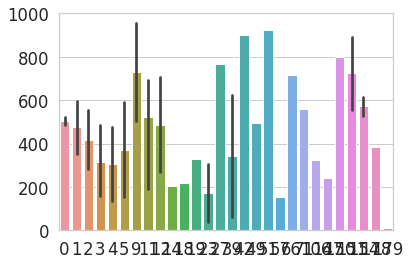

In [205]:

#sns.distplot(top_yt_url_counted_articles);
sns.barplot(top_yt_url_counted_articles.values, top_yt_url_counted_articles.index)